In [3]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import glob, pdb, os, sys, cv2
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd
from angio import angio_abm
import cv2
import numpy as np
import matplotlib.pyplot as plt


import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import networkx as nx

import matplotlib.cm as cm


In [9]:
def run(chemo, hapto):
    # In[ ]:


    #initialize simulation
    
    #### chemoattractant distribution
    # linear : profile linearly increases with x
    # tumor  : profile max as the point (1,0.5) imitating a tumor center at that location
    C_dist = 'linear'
    
    #max time units a simulation can run
    final_time = 20.0
    
    #chemotaxis rate
    chemo_rate = 'const'
    
    #how many ABM sims to run simulation
    ABM_sims = 1
    
    hapt_vec = [hapto]#np.round(np.linspace(0,.5,11),2).tolist()
    chi_vec = [chemo]#np.round(np.linspace(0,.5,11),2).tolist()
    
    psi = 0.1
    
    for i in np.arange(ABM_sims):
        
        #print(i)
        # print("")
        for hapt in hapt_vec:
            for chi in chi_vec:
    
                    
                    #initialize ABM simulation
                    A = angio_abm(C_dist,
                                  rho = hapt,
                                  t_final = final_time,
                                  chi = chi,
                                  chemo_rate = chemo_rate,
                                  psi = psi)
    
                    #initialize chemoattractant and TAF grids, sprout locations
                    A.IC_generate()
                    A.sprout_initialize()
    
                    #Record biological data (sprouts, tips, branches)
                    A.record_bio_data()
    
                    #Run the ABM until either one of the sprouts reaches x=0.95
                    #or when time exceeds max_sim_time
                    j = 0
                    max_x = 0
                    while max_x < 0.95:
    
                        #move sprouts
                        A.move_sprouts()
                        #update TAF , chemoattractant
                        A.update_grids()
                        #perform branching
                        A.branch()
    
                        #Save bio info
                        A.record_bio_data()
    
                        #max x value reached by sprout tips
                        max_x = np.max(A.X[A.N==1])
    
                        j+=1
                        if A.dt*j > final_time:
                            #stop simulation if time exceeds max_sim_time
                            break
    
                    A.save_bio_data(i)


    return A

In [10]:
def enhance_for_loops(A):
    # Assuming binary_matrix is your binary image (numpy array)
    # For demonstration, let's create a random binary matrix
    binary_matrix = A.N.T.astype(np.uint8) * 255  # Convert to 8-bit format with 0 and 255
    

    # Define a kernel for dilation (structuring element)
    kernel_size = 2  # You can adjust this size
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Apply dilation
    dilated_image = cv2.dilate(binary_matrix, kernel, iterations=1)
    
    kernel_size = kernel_size-1  # You can adjust this size
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
    
    # kernel_size = 1 # You can adjust this size
    # kernel = np.ones((kernel_size, kernel_size), np.uint8)
    # final_image = cv2.dilate(eroded_image, kernel, iterations=1)
    final_image = eroded_image.copy()
    return final_image    
    
    
    # # Display the original and dilated images
    # plt.figure(figsize=(10, 10))
    
    # plt.subplot(1, 3, 1)
    # plt.title('Original Binary Image')
    # plt.imshow(binary_matrix, cmap='gray')
    
    # plt.subplot(1, 3, 2)
    # plt.title('Dilated Image')
    # plt.imshow(dilated_image, cmap='gray')
    
    # plt.subplot(1, 3, 3)
    # plt.title('Eroded Image')
    # plt.imshow(eroded_image, cmap='gray')
    
    # plt.show()


In [11]:


def map_to_square(arr,dest):
    # Find the minimum and maximum values for each column (x and y coordinates)
    min_vals = arr.min(axis=0)
    max_vals = arr.max(axis=0)
    
    # Normalize the coordinates to [0, 1]
    norm_arr = (arr - min_vals) / (max_vals - min_vals)
    
    # Scale and shift to [-1, 1]
    shift = dest -np.array([1,0])
    scaled_arr = norm_arr * 2 +shift
    
    return scaled_arr


# Step 1: Skeletonize the Image
def skeletonize_image(binary_image):
    return skeletonize(binary_image // 255).astype(np.uint8)

# Step 2: Detect Nodes and Edges
def detect_nodes_edges(skeleton):
    # Identify all nodes
    # Use a connectivity-8 kernel to find nodes
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]], dtype=np.uint8)
    convolved = cv2.filter2D(skeleton, -1, kernel)
    
    nodes = np.where((convolved > 10) & (convolved < 18))
    
    return list(zip(nodes[1], nodes[0]))

# Step 3: Create a Graph
def create_graph(skeleton, nodes):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    
    for node in nodes:
        x, y = node
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                if skeleton[y + dy, x + dx] == 1:
                    neighbor = (x + dx, y + dy)
                    if neighbor in nodes:
                        G.add_edge(node, neighbor)
    
    return G

# Step 4: Find Cycles
def find_cycles(graph):
    cycles = list(nx.cycle_basis(graph))
    return cycles




# Optional: Visualize the results
def visualize_cycles(image, cycles):
    plt.imshow(image, cmap='gray')
    for cycle in cycles:
        cycle = np.array(cycle)
        plt.plot(cycle[:, 0], cycle[:, 1], 'r-')
    plt.show()



In [141]:
def detectLoops(final_image, plot=True):

    binary_image = cv2.threshold(final_image, 127, 255, cv2.THRESH_BINARY)[1]
    
    skeleton = skeletonize_image(binary_image)
    nodes = detect_nodes_edges(skeleton)
    graph = create_graph(skeleton, nodes)
    cycles_unfiltered = find_cycles(graph)
    
    cycles = [sublist for sublist in cycles_unfiltered if len(sublist) >= 5]
    for cycle in cycles:
        cycle.append(cycle[0])
    
    print(f"Detected {len(cycles)} cycles in the image.")

    if plot == True:
        visualize_cycles(skeleton, cycles)
    
    return skeleton, cycles, graph


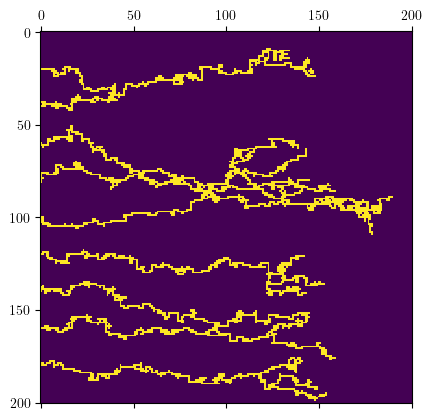

In [142]:
A = run(0.4, 0.4)
plt.matshow(A.N.T)

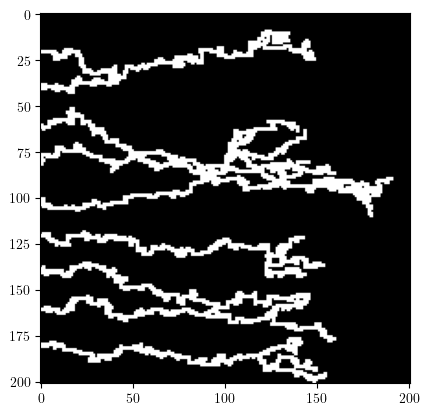

In [143]:
final_image = enhance_for_loops(A)
plt.imshow(final_image, cmap='gray')

Detected 26 cycles in the image.


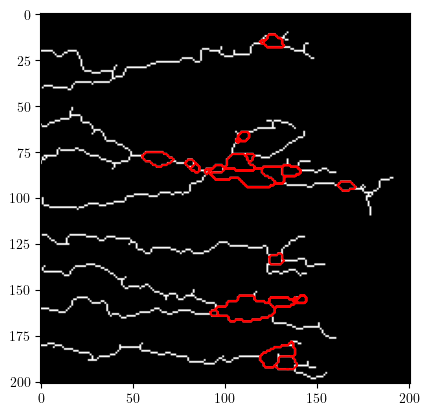

In [144]:
skeleton, cycles, graph = detectLoops(final_image)

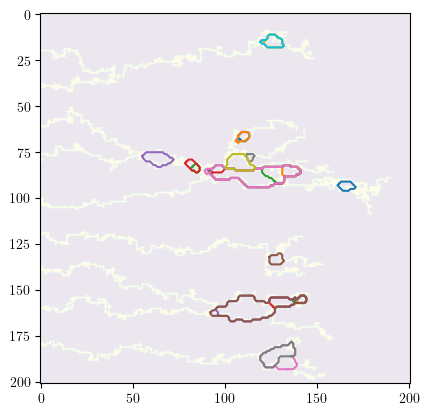

In [145]:
for cycle in cycles:
    arr = np.array(cycle)
    plt.plot(arr[:,0],arr[:,1])

plt.imshow(A.N.T,alpha=0.1)

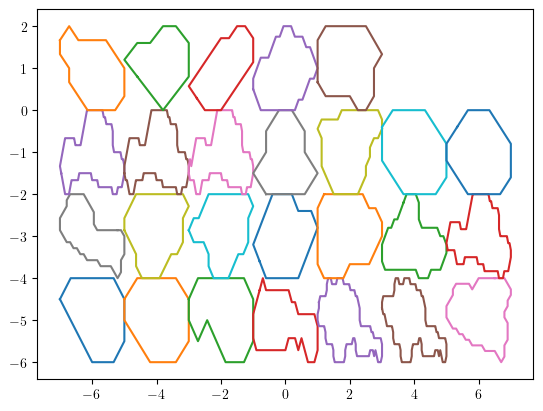

In [146]:
L = int(len(cycles)**(1/2)+1)//2
xList = np.arange(-2*L,2*(L+1),2)
X,Y = np.meshgrid(xList,xList)

i=0
for x,y in zip(X.ravel(),Y.ravel()):
    if (i < len(cycles)):
        arr = map_to_square(np.array(cycles[i]),np.array([x,y]))
        plt.plot(arr[:,0],arr[:,1])
    i+=1



In [147]:
loopSizeList = [len(cycle) for cycle in cycles]

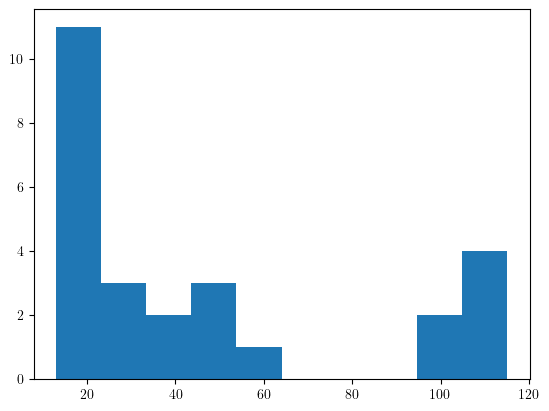

In [148]:
_ = plt.hist(loopSizeList)

Detected 28 cycles in the image.


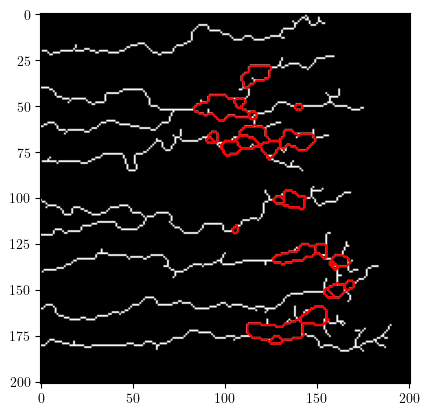

Detected 36 cycles in the image.


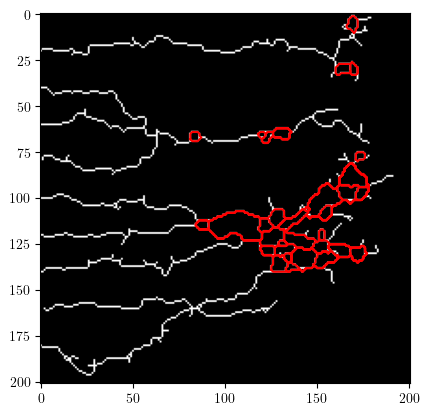

Detected 34 cycles in the image.


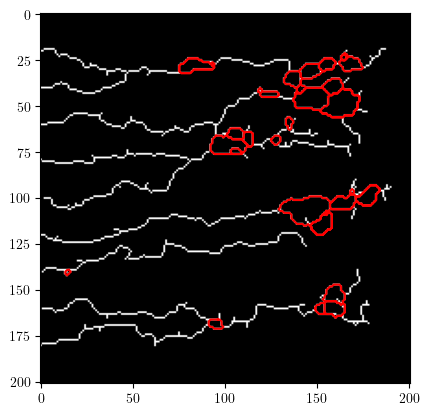

Detected 93 cycles in the image.


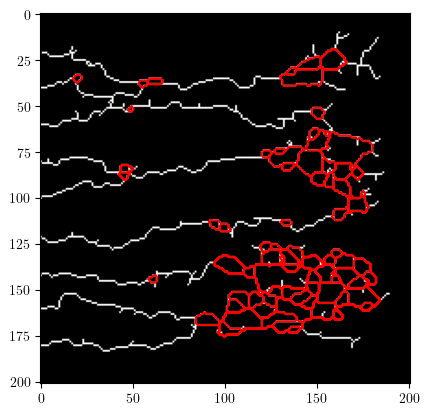

Detected 67 cycles in the image.


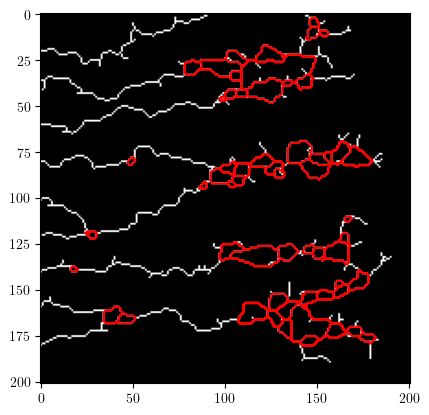

Detected 27 cycles in the image.


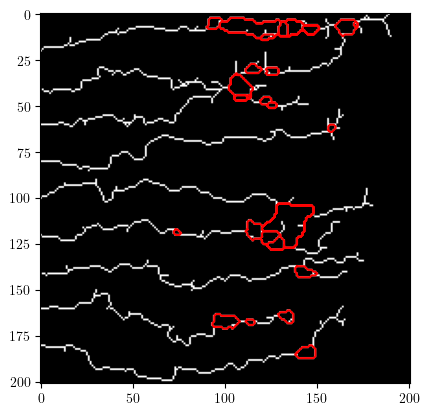

Detected 59 cycles in the image.


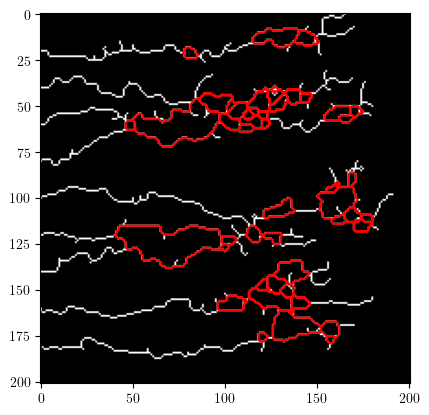

Detected 40 cycles in the image.


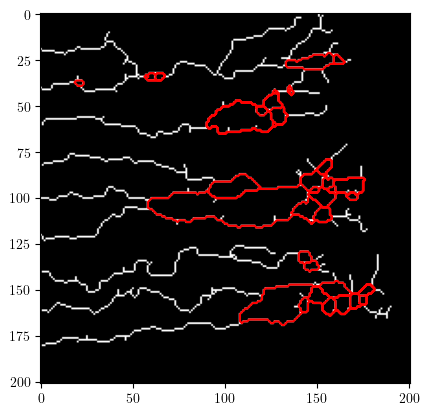

Detected 44 cycles in the image.


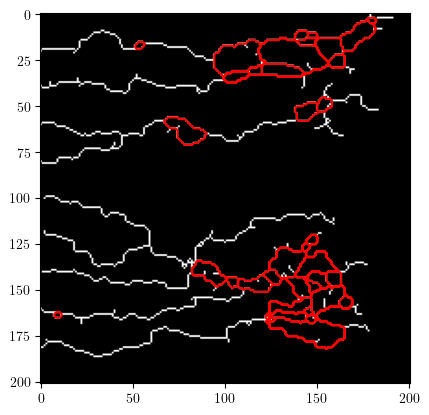

Detected 39 cycles in the image.


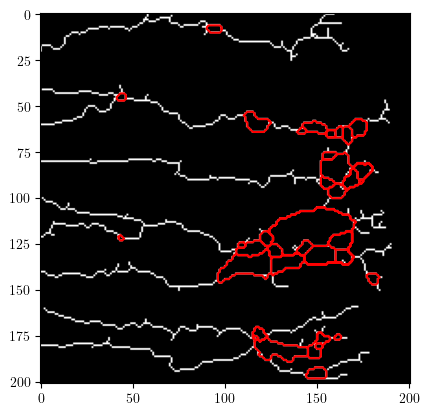

Detected 44 cycles in the image.


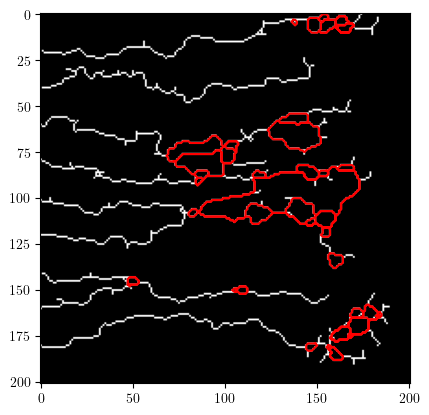

Detected 21 cycles in the image.


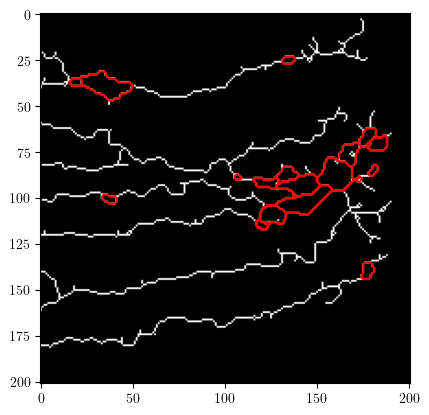

Detected 27 cycles in the image.


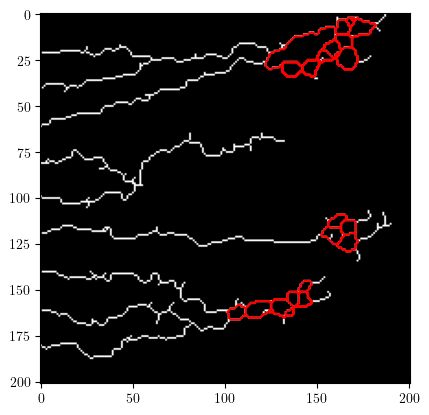

Detected 40 cycles in the image.


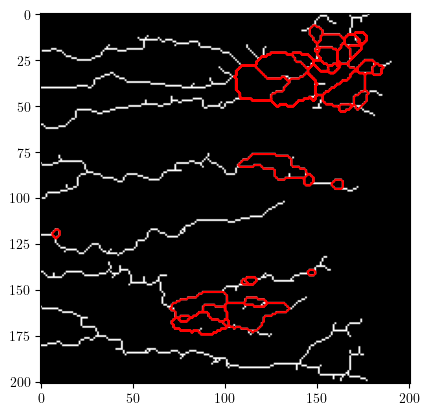

Detected 24 cycles in the image.


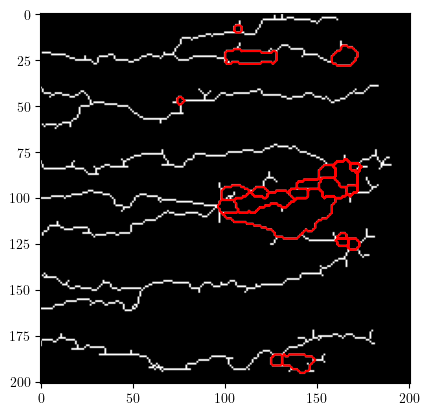

Detected 67 cycles in the image.


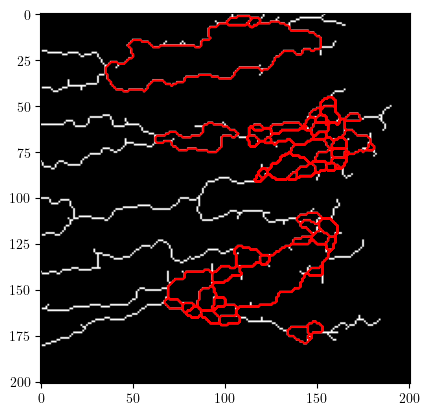

Detected 37 cycles in the image.


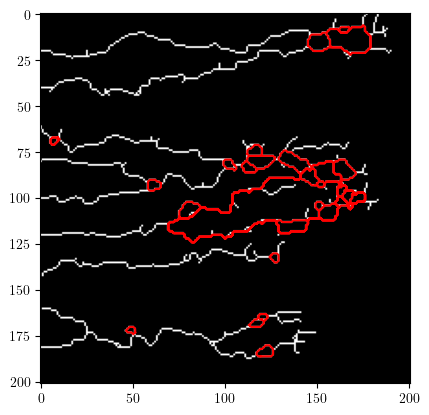

Detected 40 cycles in the image.


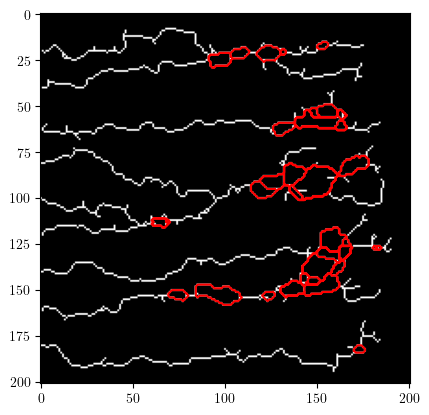

IndexError: index 201 is out of bounds for axis 0 with size 201

In [169]:
result = []
for i in range(30):
    A = run(0.4, 0.4)
    final_image = enhance_for_loops(A)
    skeleton, cycles, graph = detectLoops(final_image)
    loopSizeList = [len(cycle) for cycle in cycles]
    result += loopSizeList.copy()

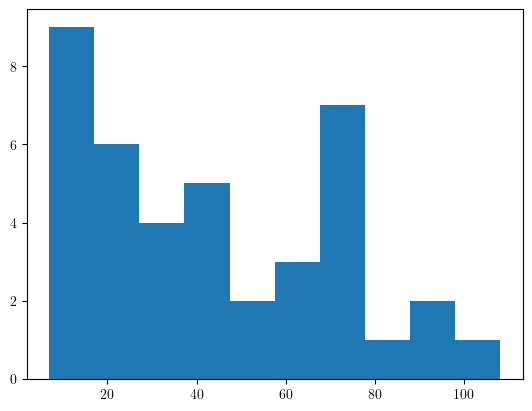

In [170]:
_ = plt.hist(loopSizeList)

Detected 1709 segments in the image.


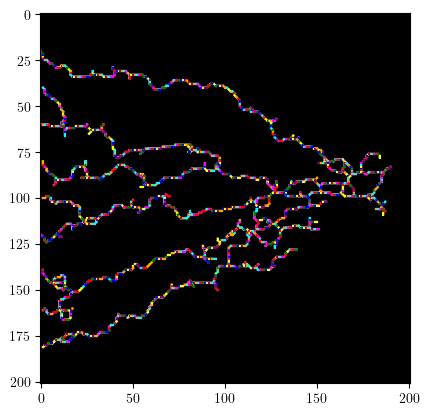

In [120]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import networkx as nx

# Step 1: Skeletonize the Image
def skeletonize_image(binary_image):
    return skeletonize(binary_image // 255).astype(np.uint8)

# Step 2: Detect Nodes and Edges
def detect_nodes_edges(skeleton):
    # Identify all nodes
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]], dtype=np.uint8)
    convolved = cv2.filter2D(skeleton, -1, kernel)
    
    nodes = np.where((convolved > 10) & (convolved < 18))
    
    return list(zip(nodes[1], nodes[0]))

# Step 3: Create a Graph
def create_graph(skeleton, nodes):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    
    for node in nodes:
        x, y = node
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                if skeleton[y + dy, x + dx] == 1:
                    neighbor = (x + dx, y + dy)
                    if neighbor in nodes:
                        G.add_edge(node, neighbor)
    
    return G

# Step 4: Find Segments
def find_segments(graph):
    segments = []
    for edge in graph.edges:
        segments.append(edge)
    return segments

# Load and preprocess the image
binary_image = cv2.threshold(final_image, 127, 255, cv2.THRESH_BINARY)[1]

skeleton = skeletonize_image(binary_image)
nodes = detect_nodes_edges(skeleton)
graph = create_graph(skeleton, nodes)
segments = find_segments(graph)

print(f"Detected {len(segments)} segments in the image.")

def visualize_segments(image, segments):
    plt.imshow(image, cmap='gray')
    colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan', 'magenta']
    for i, segment in enumerate(segments):
        x_coords, y_coords = zip(*segment)
        plt.plot(x_coords, y_coords, color=colors[i % len(colors)])
    plt.show()

visualize_segments(skeleton, segments)